# Gaussian mixture example

In [1]:
# load packages:
# package requirement: tensorflow-gpu 1.15.2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pathces
import sys

from mmDUFS import JointModel
from mmDUFS import DiffModel
from mmDUFS import DataSet
from sklearn.metrics import f1_score
from scipy import stats

Using TensorFlow backend.


In [2]:
import numpy as np

# generate multiview mixture gaussian dataset
def generate_multiview_data(n_sample_shared,n_sample_diff,n_feature_shared,n_feature_diff,n_feature_noise,mean_shared,mean_diff,diff_start_sample_idx,random_state=42):
    '''
    generate the data matrix for a single modality
    n_sample_shared: a vector of the number of samples in each shared cluster
    n_sample_diff: a vector of the number of samples in each modality specific cluster
    n_feature_shared: a vector of the number of informative features in each shared cluster
    n_feature_diff: a vector of the number of informative features in each differtial cluster
    n_feature_noise: int, the number of noisy features
    mean_shared: a vector of float, the lower bound of a random uniform draw that controls the mean of the multivariate gaussian in each shared cluster
    mean_diff: a vector of float, the lower bound of a random uniform draw that controls the mean of the multivariate gaussian in each modality specific cluster
    diff_start_sample_idx: int, sample idx where the diff structure starts
    random_state: int, seed
    '''

    rng = np.random.RandomState(seed=random_state)
    
    n_features_total = np.sum(n_feature_shared) + np.sum(n_feature_diff) + np.sum(n_feature_noise)
    n_samples_total = np.sum(n_sample_shared)
    # intialize the data matrix as the gaussian noise
    X = rng.normal(size=(n_samples_total,n_features_total))

    # 1. generate the informative features for each cluster of the shared structure
    for i,n_feature_shared_current in enumerate(n_feature_shared):

        n_sample_shared_current = n_sample_shared[i]

        mu_vec = rng.uniform(mean_shared[i],2*mean_shared[i],n_feature_shared_current)
        X_informative =  rng.multivariate_normal(mu_vec,np.eye(n_feature_shared_current),n_sample_shared_current)
        X[np.ix_(np.sum(n_sample_shared[:i]) + np.arange(n_sample_shared_current),np.sum(n_feature_shared[:i]) + np.arange(n_feature_shared_current))] =X_informative
        
    # 2. generate the informative features for each subcluster of the diff structure
    if np.sum(n_feature_diff) > 0:
        for i,n_feature_diff_current in enumerate(n_feature_diff):
            n_sample_diff_current = n_sample_diff[i]

            mu_vec = rng.uniform(mean_diff[i],2*mean_diff[i],n_feature_diff_current)
            X_diff = rng.multivariate_normal(mu_vec,np.eye(n_feature_diff_current),n_sample_diff_current)
            X[np.ix_(diff_start_sample_idx + np.sum(n_sample_diff[:i]) + np.arange(n_sample_diff_current),np.sum(n_feature_shared) + np.sum(n_feature_diff[:i]) + np.arange(n_feature_diff_current))] = X_diff
            

    
    return X
    

In [3]:
!nvidia-smi

Thu Feb 16 01:46:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 29%   25C    P8    16W / 250W |    517MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 29%   

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### dataset generation

In [5]:
X= generate_multiview_data(n_sample_shared = np.array([100,100,30,30]),
                            n_sample_diff = np.array([0]) ,
                            n_feature_shared = np.array([20,10,30,40]),
                            n_feature_diff = np.array([0]),
                            n_feature_noise = 30,
                            mean_shared = [2,2,2,2],
                            mean_diff = [0],
                            diff_start_sample_idx = 200,
                            random_state=42)
Y = generate_multiview_data(n_sample_shared = np.array([100,100,60]),
                            n_sample_diff = np.array([0]) ,
                            n_feature_shared = np.array([10,10,40]),
                            n_feature_diff = np.array([0]),
                            n_feature_noise = 30,
                            mean_shared = [2,2,2],
                            mean_diff = [0],
                            diff_start_sample_idx = 100,
                            random_state=42)
# replace the signals with noise in the last 2 cluster
rng = np.random.RandomState(seed = 42)
X[200:230,:] = rng.normal(size=X[200:230,:].shape)
Y[230:,:] = rng.normal(size=Y[230:,:].shape)

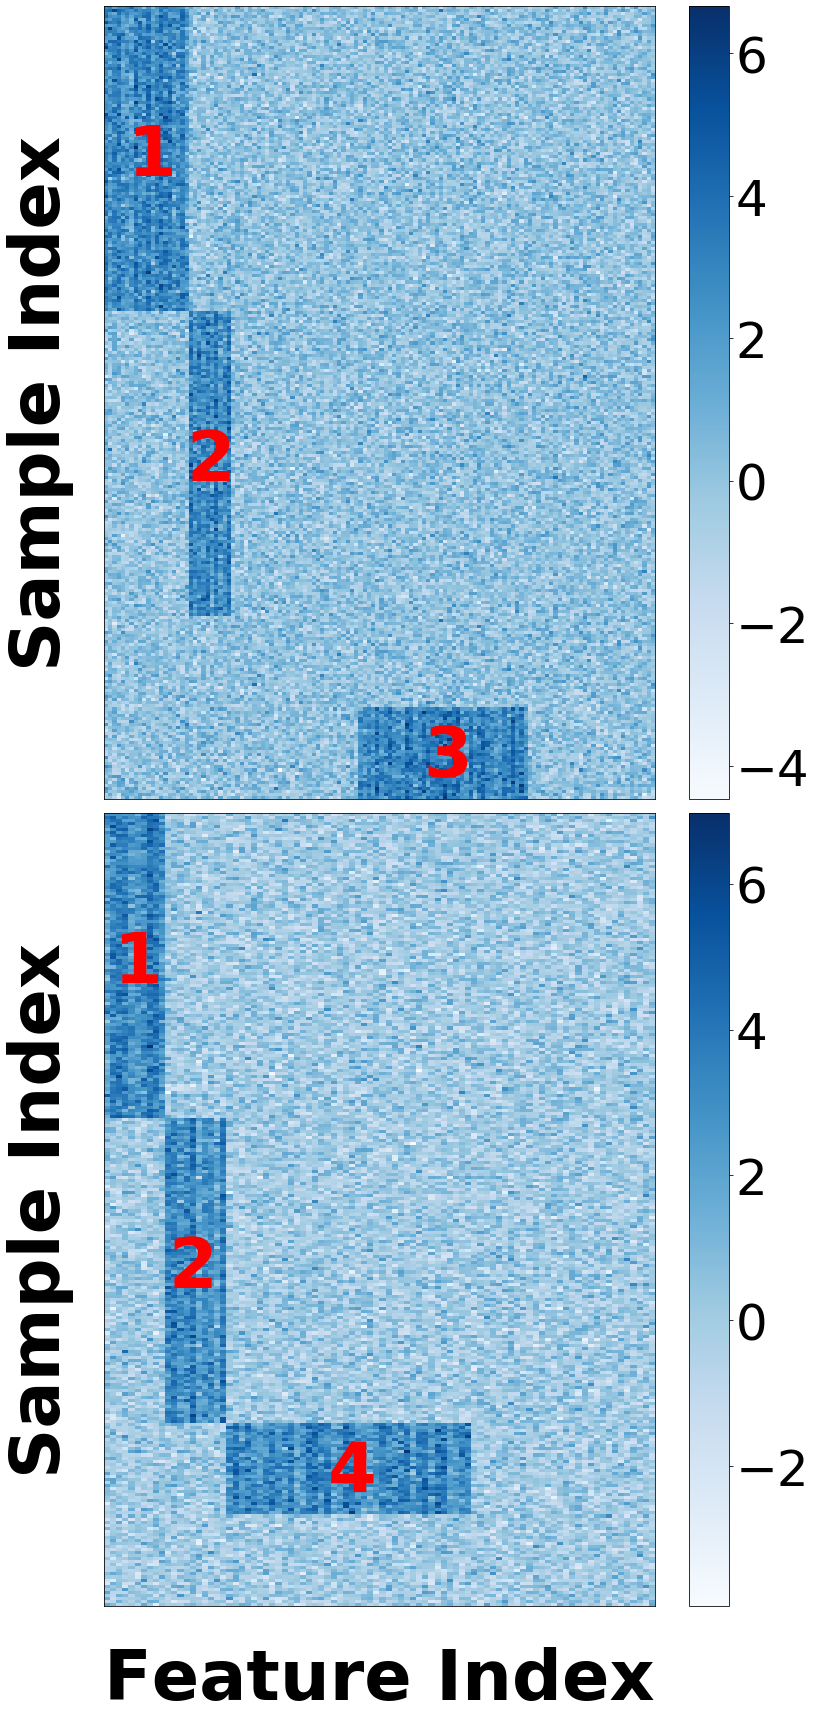

In [6]:
fig, ax = plt.subplots(2, 1,sharex=False, sharey=False,figsize=(12, 24))


cmap = cm.Blues

title_size = 35
xtick_size = 20
ytick_size = 20
xlabel_size = 70
ylabel_size = 70
colorbar_tick_size = 50
title_pad = 10
xlabel_pad = 40
ylabel_pad = 30

text_size = 70

y_ticks_1 = np.array([0,99,199,239,259,279])
y_ticks_2 = np.array([0,99,199,279])
x_ticks_1 = np.array([0,19,29,39,59,79,129])
x_ticks_2 = np.array([0,29,59,89,139])

p1 = ax[0].imshow(X,aspect='auto',cmap=cmap)
ax[0].tick_params(axis='x', labelsize=xtick_size)
ax[0].tick_params(axis='y', labelsize=ytick_size)
ax[0].annotate("1",(5,55),c="r",fontsize=text_size,fontweight="bold")
ax[0].annotate("2",(19,155),c="r",fontsize=text_size,fontweight="bold",)
ax[0].annotate("3",(75,252),c="r",fontsize=text_size,fontweight="bold",)

ax[0].get_xaxis().set_ticks([])  
ax[0].get_yaxis().set_ticks([])
ax[0].set_ylabel("Sample Index",fontsize=ylabel_size,fontweight="bold",labelpad=ylabel_pad)
cbar = fig.colorbar(p1,ax=ax[0])
cbar.ax.tick_params(labelsize=colorbar_tick_size)



p2 = ax[1].imshow(Y,aspect='auto',cmap=cmap)
ax[1].tick_params(axis='x', labelsize=xtick_size)
ax[1].tick_params(axis='y', labelsize=ytick_size)
ax[1].annotate("1",(1,55),c="r",fontsize=text_size,fontweight="bold")
ax[1].annotate("2",(10,155),c="r",fontsize=text_size,fontweight="bold",)
ax[1].annotate("4",(36,222),c="r",fontsize=text_size,fontweight="bold",)

ax[1].get_xaxis().set_ticks([])  
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel("Sample Index",fontsize=ylabel_size,fontweight="bold",labelpad=ylabel_pad)
ax[1].set_xlabel("Feature Index",fontsize=xlabel_size,fontweight="bold",labelpad=xlabel_pad)
cbar = fig.colorbar(p2,ax=ax[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()
plt.show()

In [7]:
X_z = stats.zscore(X,axis=0)
Y_z = stats.zscore(Y,axis=0)

In [8]:
# ground truth labels: shared
feature_label_joint1 = np.zeros(X.shape[1])
feature_label_joint1[:30] = 1
feature_label_joint2 = np.zeros(Y.shape[1])
feature_label_joint2[:20] = 1

In [9]:
# ground truth labels: diff
feature_label_diff1 = np.zeros(X_z.shape[1])
feature_label_diff1[60:100] =1

feature_label_diff2 = np.zeros(Y_z.shape[1])
feature_label_diff2[20:60] =1

In [10]:
# cluster labels: only used for plotting
ylabel = np.hstack((np.repeat(0,100),
                    np.repeat(1,100),
                    np.repeat(2,30),
                    np.repeat(3,30))
                   )

# mmDUFS with the shared operator

In [11]:
shared_mmdufs_params = {
    "lam1":1e-4, # lambda x
    "lam2":1e-4, # lambda y
    "batch_size":X_z.shape[0], # full batch
}
shared_mmdfus_learning_rate = 2
display_step = 1000
epochs = 10000

In [12]:
dataset = DataSet(**{'_data1':X_z,
                         '_data2':Y_z,
                         '_labels':ylabel},
                      labeled=True)

shared_mmdufs_params["input_dim1"] = X_z.shape[1]
shared_mmdufs_params["input_dim2"] = Y_z.shape[1]
    
model = JointModel(**shared_mmdufs_params) 
    
shared_result= model.train(dataset,
                            learning_rate=shared_mmdfus_learning_rate,
                        feature_label1 = feature_label_joint1, 
                        feature_label2 = feature_label_joint2,
                        display_step=display_step, 
                        num_epoch=epochs,labeled=True) #30000







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 260
Epoch: 1000 loss= -0.002161158 score1= -0.001060919 score2= -0.001269356 reg1= 0.844962180 reg2= 0.846214652 f1 - Mod1 =  0.7059 f1 - Mod2 =  0.6897
Epoch: 2000 loss= -0.002391755 score1= -0.001348281 score2= -0.001213274 reg1= 0.848479867 reg2= 0.849524796 f1 - Mod1 =  0.8333 f1 - Mod2 =  0.9524
Epoch: 3000 loss= -0.002660752 score1= -0.001388329 score2= -0.001442182 reg1= 0.850486219 reg2= 0.847109556 f1 - Mod1 =  0.9231 f1 - Mod2 =  1.0000
Epoch: 4000 loss= -0.006177763 score1= -0.002810090 score2= -0.003

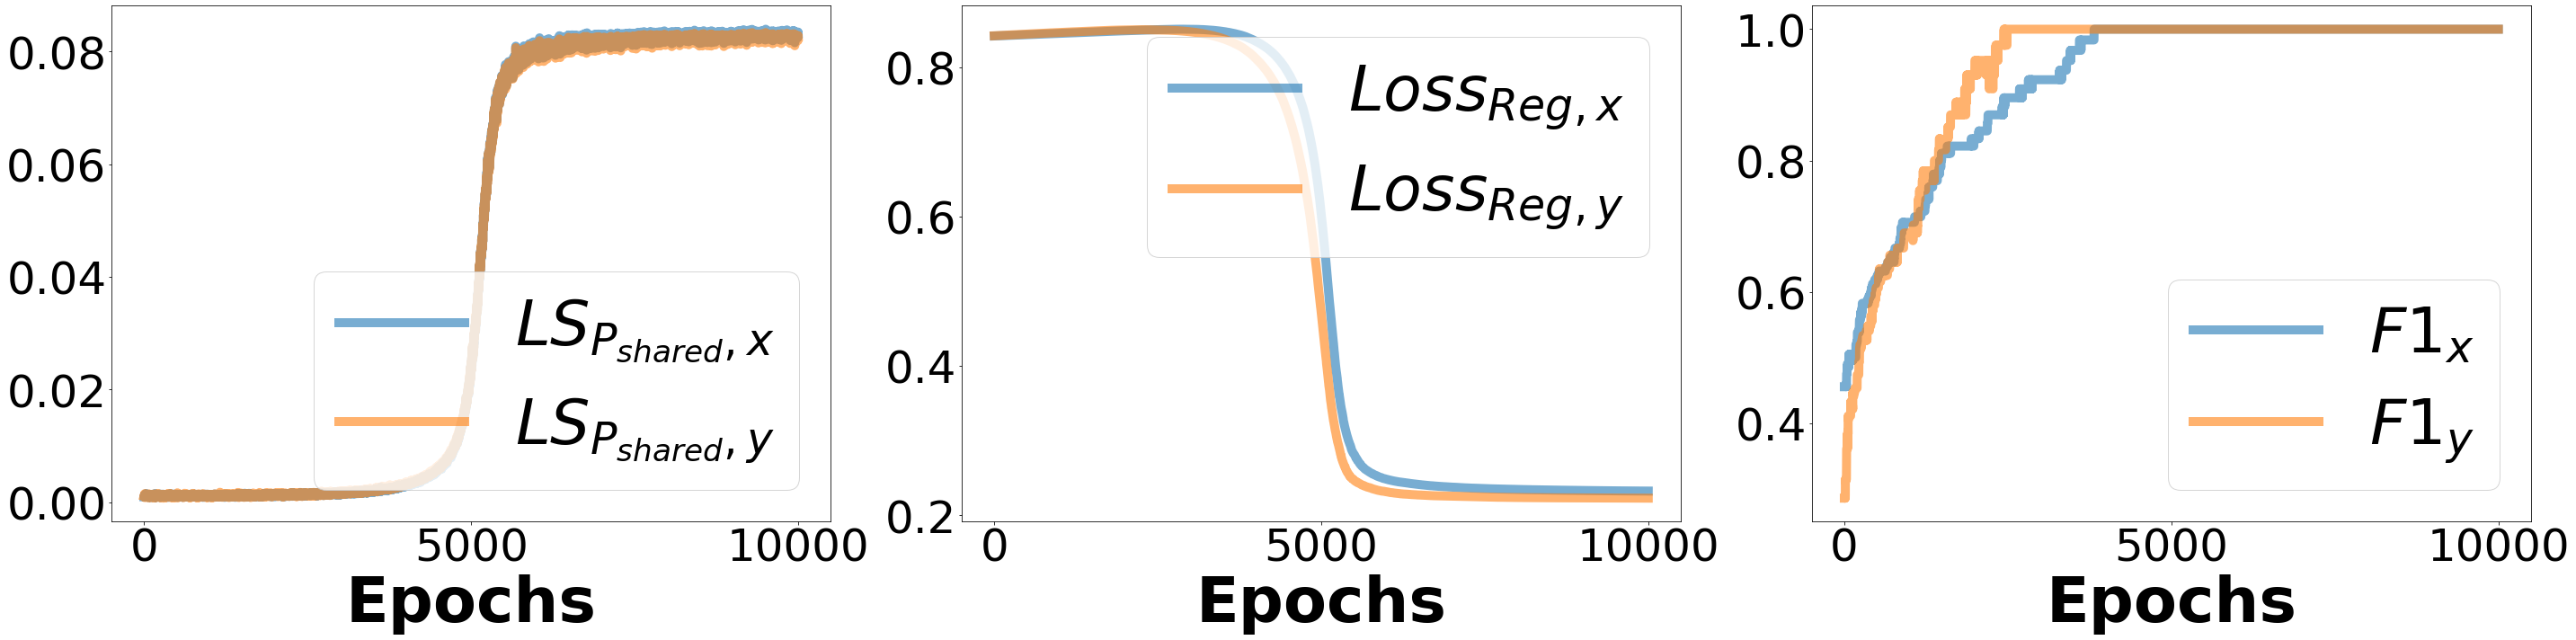

In [13]:
fig1,axs = plt.subplots(1,3,figsize=(40,10),sharex=False,sharey=False)
fig1.set_facecolor('w')
fig1.set_facecolor('w')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
fig1.set_facecolor('w')
fig1.set_facecolor('w')


epochs2show_joint = 10000
epochs2show_diff = 10000

s=30
xtick_size = 40
ytick_size = 40
tick_label_size=50
tick_pad =2
alpha = 0.6
xlabel_size = 70
ylabel_size = 70
legend_font_size = 70
colorbar_tick_size = 50
title_size=55
lw = 10
annotation_size = 60

axs[0].plot(np.abs(shared_result[0][:epochs2show_joint]),label="$LS_{P_{shared},x}$",lw=lw,alpha=alpha)
axs[0].plot(np.abs(shared_result[1][:epochs2show_joint]),label="$LS_{P_{shared},y}$",lw=lw,alpha=alpha)
axs[0].legend(fontsize=legend_font_size,loc='lower right')
axs[0].get_xaxis().set_ticks([0,5000,10000])
#axs[0,1].set_ylabel("Laplacian Score",fontsize=ylabel_size)
axs[0].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[0].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")

#axs[0,1].text(-0.2, 1.05, "b", transform=axs[0,1].transAxes, 
#            size=annotation_size, weight='bold')


axs[1].plot(shared_result[3][:epochs2show_joint],label="$Loss_{Reg,x}$",lw=lw,alpha=alpha)
axs[1].plot(shared_result[4][:epochs2show_joint],label="$Loss_{Reg,y}$",lw=lw,alpha=alpha)
axs[1].legend(fontsize=legend_font_size,loc='upper right')
axs[1].get_xaxis().set_ticks([0,5000,10000])
#axs[0,1].set_ylabel("Regularization Loss",fontsize=ylabel_size)
axs[1].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[1].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")




axs[2].plot(shared_result[-4][:epochs2show_joint],label="$F1_x$",alpha=alpha,lw=lw)
axs[2].plot(shared_result[-3][:epochs2show_joint],label="$F1_y$",alpha=alpha,lw=lw)
axs[2].legend(fontsize=legend_font_size,loc='lower right')
axs[2].get_xaxis().set_ticks([0,5000,10000])
#axs[0,2].set_ylabel("F1 Score",fontsize=ylabel_size)
axs[2].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[2].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")


plt.tight_layout()

plt.show()

# mmDUFS with the differential operator

#### X-specific

In [14]:
diff_mvdufs_params = {
    'lam1':0.4, # lambda x
    'input_dim1':X_z.shape[1],
    'input_dim2':Y_z.shape[1],
    'batch_size':X_z.shape[0],
    'const':1e-1, # c
    'const2':1e-1, # b
}
diff_mvdfus_learning_rate = 1
display_step = 500
epochs = 10000

In [15]:
dataset = DataSet(**{'_data1':X_z,
                         '_data2':Y_z,
                         '_labels':ylabel},
                      labeled=True)

In [16]:
diff_model1 = DiffModel(**diff_mvdufs_params) 
diff_result1 = diff_model1.train(dataset,
                              learning_rate=diff_mvdfus_learning_rate,
                              display_step=display_step, 
                         feature_label = feature_label_diff1,
                         num_epoch=epochs,
                              labeled=True) #30000


num_samples : 260
Epoch: 0500 loss= -0.400622934 score1= -0.521991730 reg1= 0.303421974 f1= 0.9474
Epoch: 1000 loss= -0.429578096 score1= -0.543136120 reg1= 0.283895075 f1= 0.9474
Epoch: 1500 loss= -0.433208972 score1= -0.545540631 reg1= 0.280829132 f1= 0.9474
Epoch: 2000 loss= -0.433873892 score1= -0.545734525 reg1= 0.279651552 f1= 0.9474
Epoch: 2500 loss= -0.432471991 score1= -0.544070125 reg1= 0.278995335 f1= 0.9474
Epoch: 3000 loss= -0.434574276 score1= -0.545998752 reg1= 0.278561205 f1= 0.9474
Epoch: 3500 loss= -0.434047818 score1= -0.545360804 reg1= 0.278282464 f1= 0.9474
Epoch: 4000 loss= -0.433977604 score1= -0.545211852 reg1= 0.278085619 f1= 0.9474
Epoch: 4500 loss= -0.434934646 score1= -0.546107531 reg1= 0.277932197 f1= 0.9474
Epoch: 5000 loss= -0.435484588 score1= -0.546612561 reg1= 0.277819902 f1= 0.9474
Epoch: 5500 loss= -0.435222656 score1= -0.546315312 reg1= 0.277731657 f1= 0.9474
Epoch: 6000 loss= -0.435559839 score1= -0.546620727 reg1= 0.277652204 f1= 0.9474
Epoch: 650

#### y-specific

In [17]:
diff_mvdufs_params = {
    'lam1':0.4,
    'input_dim1':Y_z.shape[1],
    'input_dim2':X_z.shape[1],
    "batch_size":Y_z.shape[0],
    'const':1e-1, 
    'const2':1e-1,
}
diff_mvdfus_learning_rate = 1
display_step = 500
epochs = 10000

In [18]:
dataset = DataSet(**{'_data1':Y_z,
                         '_data2':X_z,
                         '_labels':ylabel},
                      labeled=True)

In [19]:
diff_model2 = DiffModel(**diff_mvdufs_params) 
diff_result2 = diff_model2.train(dataset,
                              learning_rate=diff_mvdfus_learning_rate,
                              display_step=display_step, 
                         feature_label = feature_label_diff2,
                         num_epoch=epochs,
                              labeled=True) #30000


num_samples : 260
Epoch: 0500 loss= -0.717871547 score1= -0.876415610 reg1= 0.396360189 f1= 0.9333
Epoch: 1000 loss= -0.720321655 score1= -0.876892269 reg1= 0.391426474 f1= 0.9333
Epoch: 1500 loss= -0.725257754 score1= -0.881368876 reg1= 0.390277803 f1= 0.9333
Epoch: 2000 loss= -0.725327730 score1= -0.881271362 reg1= 0.389858991 f1= 0.9333
Epoch: 2500 loss= -0.725521684 score1= -0.881363094 reg1= 0.389603585 f1= 0.9333
Epoch: 3000 loss= -0.725597441 score1= -0.881381571 reg1= 0.389460325 f1= 0.9333
Epoch: 3500 loss= -0.725597501 score1= -0.881338477 reg1= 0.389352441 f1= 0.9333
Epoch: 4000 loss= -0.725660741 score1= -0.881375790 reg1= 0.389287591 f1= 0.9333
Epoch: 4500 loss= -0.725598514 score1= -0.881290734 reg1= 0.389230520 f1= 0.9333
Epoch: 5000 loss= -0.725057125 score1= -0.880735099 reg1= 0.389194995 f1= 0.9333
Epoch: 5500 loss= -0.725711346 score1= -0.881375730 reg1= 0.389160901 f1= 0.9333
Epoch: 6000 loss= -0.725444078 score1= -0.881096601 reg1= 0.389131278 f1= 0.9333
Epoch: 650

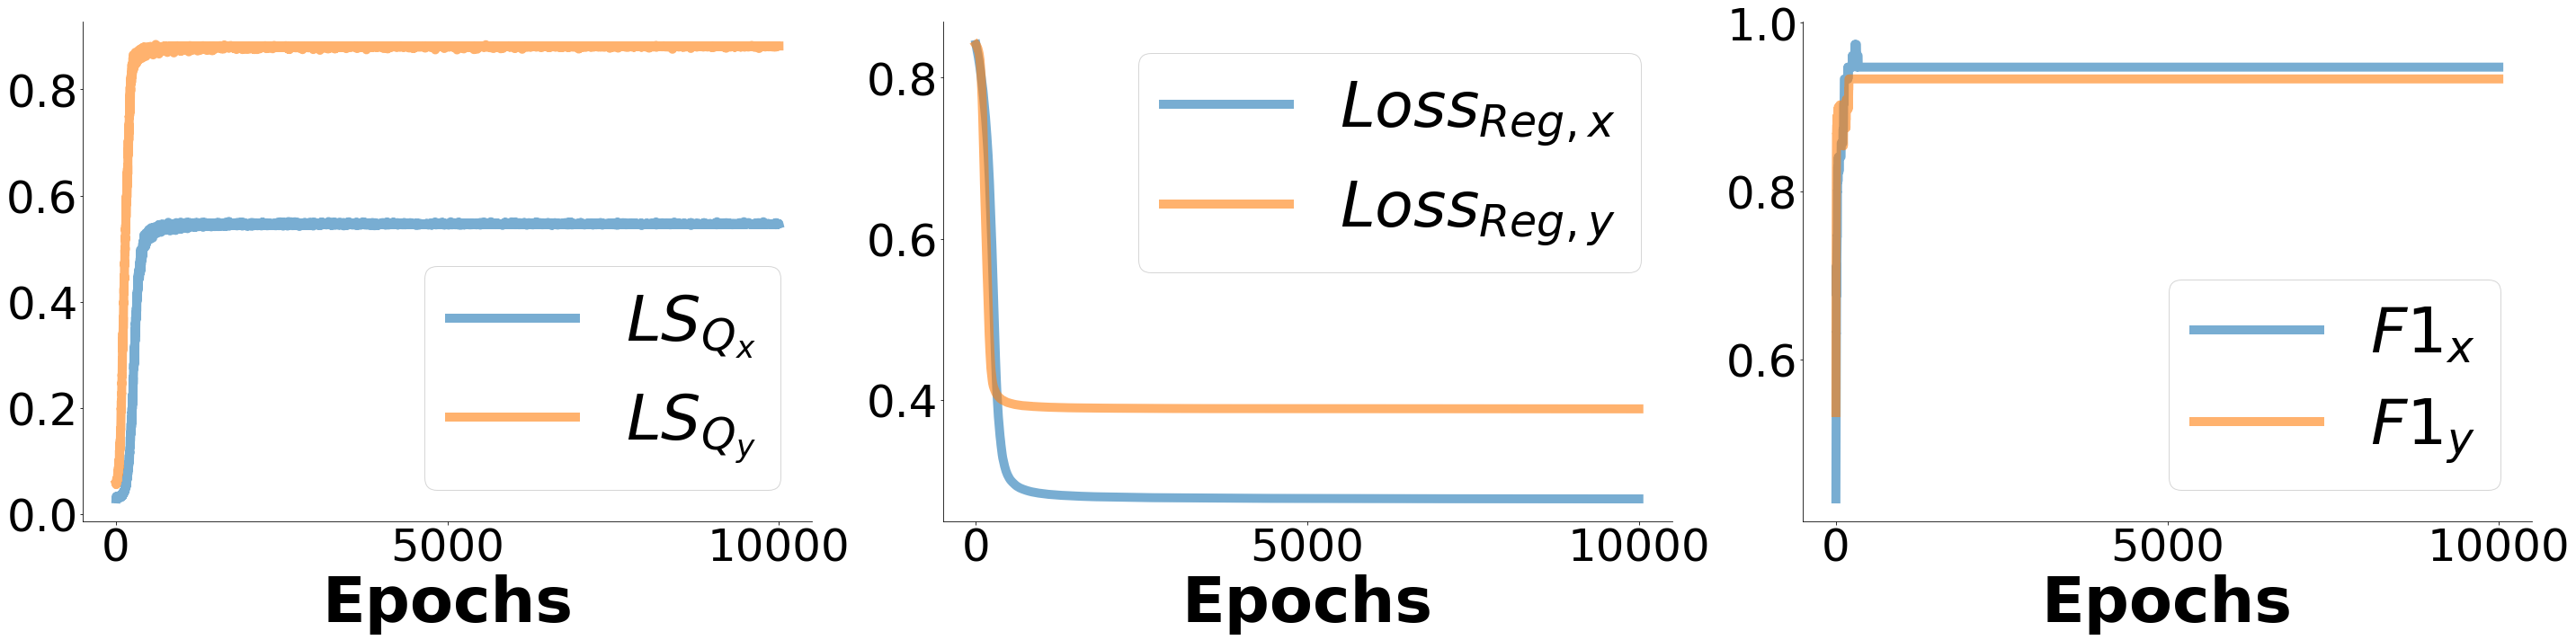

In [20]:
fig1,axs = plt.subplots(1,3,figsize=(40,10),sharex=False,sharey=False)
fig1.set_facecolor('w')
fig1.set_facecolor('w')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
fig1.set_facecolor('w')
fig1.set_facecolor('w')


axs[0].plot(np.abs(diff_result1[0][:epochs2show_diff]),label="$LS_{Q_{x}}$",lw=lw,alpha=alpha)
axs[0].plot(np.abs(diff_result2[0][:epochs2show_diff]),label="$LS_{Q_{y}}$",lw=lw,alpha=alpha)
axs[0].legend(fontsize=legend_font_size,loc='lower right')
axs[0].get_xaxis().set_ticks([0,5000,10000])
#axs[0,1].set_ylabel("Laplacian Score",fontsize=ylabel_size)
axs[0].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[0].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")

#axs[0,1].text(-0.2, 1.05, "b", transform=axs[0,1].transAxes, 
#            size=annotation_size, weight='bold')


axs[1].plot(diff_result1[2][:epochs2show_diff],label="$Loss_{Reg,x}$",lw=lw,alpha=alpha)
axs[1].plot(diff_result2[2][:epochs2show_diff],label="$Loss_{Reg,y}$",lw=lw,alpha=alpha)
axs[1].legend(fontsize=legend_font_size,loc='upper right')
axs[1].get_xaxis().set_ticks([0,5000,10000])
#axs[0,1].set_ylabel("Regularization Loss",fontsize=ylabel_size)
axs[1].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[1].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")




axs[2].plot(diff_result1[-2][:epochs2show_diff],label="$F1_{x}$",alpha=alpha,lw=lw)
axs[2].plot(diff_result2[-2][:epochs2show_diff],label="$F1_{y}$",alpha=alpha,lw=lw)
axs[2].legend(fontsize=legend_font_size,loc='lower right')
axs[2].get_xaxis().set_ticks([0,5000,10000])
#axs[0,2].set_ylabel("F1 Score",fontsize=ylabel_size)
axs[2].tick_params(labelsize=tick_label_size,pad=tick_pad)
axs[2].set_xlabel("Epochs",fontsize=xlabel_size,fontweight="bold")


plt.tight_layout()

plt.show()